# Analysis and visualization of crimes in Chicago

![](https://sites.psu.edu/aspsy/files/2017/03/chicago-u8nahk.jpg)

#### Authors: Karl Arnar Ægisson and Thomas Ari Bech

### Table of contents

1. Introduction
2. Required libraries
3. The data
  1. Importing, checking and cleaning the data
      1. Chicago Crimes dataset
      2. Community Area dataset
  2. Joining the datasets together
4. Exploring the features
5. Predictive Analysis

### Introduction

Crime in Chicago has been making headlines lately but in 2016, Chicago was responsible for nearly half of 2016's increase in homicides in the US, even though the nation's crime rates remain near historic lows.

Is Chicago seperating from the nation when it comes to crimes, or is it simply experiencing a surge in homicide rates?

In this notebook we will be trying to answer those questions.

### Required libraries

Along with Python we will be using several Python packages, these packages are:
* **NumPy** - Adds support for fast numerical array structure, along with helper functions.
* **pandas** - Provides a high-performance DataFrame structure.
* **matplotlib** - Plotting library for Python and NumPy.
* **Seaborn** - Advanced statistical plotting library.
* **scikit-learn** - Machine Learning package.
* **calendar** - Allows the calculations for various task based on date, month, and year.
* **folium** - Helps visualize the data.
* **ipywidgets** - Interactive HTML widgets for Jupyter notebooks and the IPython kernel

Before importing you need to install the folium module on your Anacona prompt:

`$ conda install -c conda-forge folium`

Let's import these packages:

In [53]:
# libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import calendar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import folium
from folium.plugins import HeatMap
from folium import IFrame, FeatureGroup, LayerControl, Map, Marker, plugins
from ipywidgets import interact

### The data

We will be using a data that is released by the City of Chicago. The data contains reported incidents of crime that occured in Chicago between 2012 to 2017. The data has the following attributes:


| **Attribute**   | **Description** |
| :------------  | :------------- |
| *ID* | Unique identifier for the record |
| *Case Number* | The Chicago Police Department RD Number (Records Division Number), which is unique to the incident |
| *Date* | Date when the incident occurred. this is sometimes a best estimate |
| *Block* | The partially redacted address where the incident occurred, placing it on the same block as the actual address |
| *IUCR* | The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description |
| *Primary Type* | The primary description of the IUCR code |
| *Description* | The secondary description of the IUCR code, a subcategory of the primary description |
| *Location Description* | Description of the location where the incident occurred |
| *Arrest* | Indicates whether an arrest was made |
| *Domestic* | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act |
| *Beat* | Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car |
| *District* | Indicates the police district where the incident occurred |
| *Ward* | The ward (City Council district) where the incident occurred |
| *Community Area* | Indicates the community area where the incident occurred. Chicago has 77 community areas |
| *FBI Code* | Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS) |
| *X Coordinate* | The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection |
| *Y Coordinate* | The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection |
| *Year* | Year the incident occurred |
| *Updated On* | Date and time the record was last updated |
| *Latitude* | The latitude of the location where the incident occurred |
| *Longitude* | The longitude of the location where the incident occurred |
| *Location* | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal |


Since the data contains several attributes that we will not be using, we will drop these attributes from the DataFrame:
* Case Number
* IUCR
* Description
* Beat
* District
* Ward
* FBI Code
* X Coordinate
* Y Coordinate
* Year
* Updated On

Which will leave us with these attributes:
* ID
* Date
* Block
* Primary Type
* Location Description
* Arrest
* Domestic
* Community Area
* Latitude
* Longitude
* Location

We will also be importing another dataset that we will merge with this dataset. The data contains various information on community areas in Chicago and was downloaded from https://github.com/dssg/411-on-311

This data has the following attributes:

| **Attribute**   | **Description** |
| :------------  | :------------- |
| *Community Area* | The unique number for each community area (total 77) |
| *Name* | The name for the community area |
| *Population* | The population for the community area |
| *Income* | The income for the community area |
| *Requests* | Service requests for the community area |
| *Latinos* | Percentage of latinos in the community area |
| *Blacks* | Percentage of blacks in the community area |
| *White* | Percentage of whites in the community area |
| *Asian* | Percentage of asians in the community area |
| *Other* | Percentage of other races in the community area |

From this dataset, we will need to drop the requests and then reshape the data so we can join it to the other data on the Community Area number.

### Importing, checking and cleaning the data

#### Chicago Crimes dataset

We will start by importing the Chicago Crimes Data and checking the data so that we can clean it. Next we will check the Community Area Data and clean it. Then we will merge the data together.

In [2]:
# chiCrimes will be the uncleaned original database
chiCrimes = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', na_values=['NA']) # Reads the .csv file and converts it to a dataframe called chiCrimes
chiCrimes.info() # Displays the information about the database
chiCrimes.head(5) # Displays the first five entries in the database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456714 entries, 0 to 1456713
Data columns (total 23 columns):
Unnamed: 0              1456714 non-null int64
ID                      1456714 non-null int64
Case Number             1456713 non-null object
Date                    1456714 non-null object
Block                   1456714 non-null object
IUCR                    1456714 non-null object
Primary Type            1456714 non-null object
Description             1456714 non-null object
Location Description    1455056 non-null object
Arrest                  1456714 non-null bool
Domestic                1456714 non-null bool
Beat                    1456714 non-null int64
District                1456713 non-null float64
Ward                    1456700 non-null float64
Community Area          1456674 non-null float64
FBI Code                1456714 non-null object
X Coordinate            1419631 non-null float64
Y Coordinate            1419631 non-null float64
Year                    1

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


We can see that there are a total of 1.456.714 records in the data.

Let's drop those features that we aren't going to use and let's see the DataFrame again.

In [3]:
chiCrimes.drop(['Unnamed: 0', 'Case Number', 'IUCR', 'Description', 'Beat', 'District',
                'Ward', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On'], inplace=True, axis=1) #dropping rows
chiCrimes.info()
chiCrimes.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456714 entries, 0 to 1456713
Data columns (total 11 columns):
ID                      1456714 non-null int64
Date                    1456714 non-null object
Block                   1456714 non-null object
Primary Type            1456714 non-null object
Location Description    1455056 non-null object
Arrest                  1456714 non-null bool
Domestic                1456714 non-null bool
Community Area          1456674 non-null float64
Latitude                1419631 non-null float64
Longitude               1419631 non-null float64
Location                1419631 non-null object
dtypes: bool(2), float64(3), int64(1), object(5)
memory usage: 102.8+ MB


,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
0,10508693,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,BATTERY,APARTMENT,True,True,29.0,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,10508695,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,BATTERY,RESIDENCE,False,True,42.0,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,10508697,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,STREET,False,False,25.0,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,10508698,05/03/2016 10:10:00 PM,049XX W FULTON ST,BATTERY,SIDEWALK,False,False,25.0,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,10508699,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,THEFT,RESIDENCE,False,True,25.0,41.886297,-87.761751,"(41.886297242, -87.761750709)"


That leaves us with a total of 11 columns (features).

Next step is to check if the data contains any duplicates, and if they do, drop those rows. Since we know that the ID is a unique identifier for the record, we will check if there are duplicate ID's.

In [4]:
bool_s = chiCrimes.duplicated(keep=False)
chiCrimes[bool_s].sort_values("ID")

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location


Great! We can see that the data contains no duplicate records according to the ID.

Let's check how many null values there is for every column:

In [5]:
chiCrimes.isnull().sum()

ID                          0
Date                        0
Block                       0
Primary Type                0
Location Description     1658
Arrest                      0
Domestic                    0
Community Area             40
Latitude                37083
Longitude               37083
Location                37083
dtype: int64

Here we can see that there are 6 columns that contain null values, and 5 columns that do. Let's work on either removing those rows that have null values, or trying to check if we can estimate the value that is missing.
  
We can see that Latitude, Longitude and Location all have the same amount of missing values, let's create a subset of chiCrimes where the location is null.



In [6]:
loc_subset = chiCrimes[['Location']] # creating a subset with only Location row
loc = chiCrimes[loc_subset.isnull().any(axis=1)] # checking if there is a row in Location that contains a null value
loc

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
154,10514462,01/01/2015 12:00:00 AM,073XX S EXCHANGE AVE,CRIM SEXUAL ASSAULT,NURSING HOME/RETIREMENT HOME,False,False,43.0,NaN,NaN,NaN
155,10515115,03/21/2016 09:00:00 AM,082XX S MARSHFIELD AVE,DECEPTIVE PRACTICE,ATM (AUTOMATIC TELLER MACHINE),False,False,71.0,NaN,NaN,NaN
156,10515155,04/01/2016 03:00:00 PM,061XX S DREXEL AVE,THEFT,RESIDENCE,False,False,42.0,NaN,NaN,NaN
157,10515175,11/24/2015 05:30:00 PM,033XX W ADAMS ST,THEFT,RESIDENCE,False,False,27.0,NaN,NaN,NaN
158,10515182,04/01/2016 12:30:00 PM,030XX W ARMITAGE AVE,OTHER OFFENSE,RESIDENCE,False,True,22.0,NaN,NaN,NaN
159,10515257,04/05/2016 12:01:00 AM,006XX W BARRY AVE,DECEPTIVE PRACTICE,RESIDENCE,False,False,6.0,NaN,NaN,NaN
160,10515292,01/15/2016 09:00:00 AM,013XX N KOSTNER AVE,THEFT,COMMERCIAL / BUSINESS OFFICE,False,False,23.0,NaN,NaN,NaN
161,10515294,01/01/2016 12:00:00 AM,041XX N MARINE DR,OBSCENITY,"SCHOOL, PUBLIC, BUILDING",True,False,3.0,NaN,NaN,NaN
162,10515309,04/12/2016 04:00:00 PM,011XX E 95TH ST,ASSAULT,STREET,False,False,47.0,NaN,NaN,NaN
164,10515417,01/01/2016 12:01:00 AM,124XX S NORMAL AVE,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,False,53.0,NaN,NaN,NaN


There are 37.083 rows that have null values, since we cannot find the location and we will be needing the location, we will drop these rows, which amounts to 2.55%. (We could try to classify the location based on block, but we haven't yet found a solution that allows us to do that fast for 37K rows.)

After dropping these rows, we should have 1.419.631 rows in 9 rows, with missing values in 2 rows.

In [8]:
chiCrimes = chiCrimes.dropna(subset=['Latitude', 'Longitude', 'Location']) #dropping rows that contain null value in these columns
print(chiCrimes.isnull().sum())
chiCrimes.count()

ID                         0
Date                       0
Block                      0
Primary Type               0
Location Description    1226
Arrest                     0
Domestic                   0
Community Area            25
Latitude                   0
Longitude                  0
Location                   0
dtype: int64


ID                      1419631
Date                    1419631
Block                   1419631
Primary Type            1419631
Location Description    1418405
Arrest                  1419631
Domestic                1419631
Community Area          1419606
Latitude                1419631
Longitude               1419631
Location                1419631
dtype: int64

We can see that the rows containing no null values are now 1.419.631.

Next, let's check how many locations are outside of the coordinates of Chicago since we won't be able to use them. We will create a subset called invalidloc, which contain all locations that have Longitude lower than -90.

In [9]:
invalidloc_subset = chiCrimes['Longitude']
invalidloc = chiCrimes[invalidloc_subset < -90] # subset with rows where Longitude is < -90
invalidloc

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
78556,8423522,01/03/2012 05:33:00 AM,017XX W 80TH ST,BATTERY,STREET,False,True,71.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
84975,8436170,01/10/2012 11:00:00 PM,035XX W 54TH PL,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",False,False,63.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
102034,8465236,01/04/2012 06:03:00 PM,099XX S CONFIDENTIAL ST,NARCOTICS,VEHICLE NON-COMMERCIAL,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
116741,8488455,02/20/2012 11:44:00 AM,062XX W KENNEDY EXPY IB,NARCOTICS,STREET,True,False,11.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
119233,8492826,02/23/2012 09:35:00 AM,035XX W 54TH PL,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",True,False,63.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
119877,8493911,02/24/2012 09:20:00 AM,022XX N KENNEDY EXPY IB,PUBLIC PEACE VIOLATION,VEHICLE NON-COMMERCIAL,True,False,22.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
174204,8582892,04/09/2012 10:05:00 AM,099XX S CONFIDENTIAL ST,NARCOTICS,RESIDENCE,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
188517,8606659,04/13/2012 11:00:00 AM,099XX S CONFIDENTIAL,NARCOTICS,SIDEWALK,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
190122,8609119,05/12/2012 02:20:00 AM,020XX W NORTH AVE,BATTERY,STREET,False,True,24.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
198275,8621613,05/20/2012 08:35:00 PM,020XX W NORTH AVE,BATTERY,STREET,False,False,24.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"


As we can see there are 77 rows that have locations far outside of Chicago and Illinois.

Lets try to fix those by finding another row with the same block value but a valid location.

We will do that by iterating through the rows in the subset we created previously, invalidloc and find the mode value of the location for that block. Then we will assign the location coordinates for the invalid locations.

In [10]:
for index, row in invalidloc.iterrows(): # iterating through invalidloc subset
    location = eval(chiCrimes.loc[chiCrimes['Block'] == row['Block']].mode()['Location'][:1][0]) #mode value of location
    if location[1] > -90:
        chiCrimes.at[index, 'Location'] = location
        chiCrimes.at[index, 'Latitude'] = location[0]
        chiCrimes.at[index, 'Longitude'] = location[1]
invalidloc_subset = chiCrimes['Longitude']
invalidloc = chiCrimes[invalidloc_subset < -90]
invalidloc

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
84975,8436170,01/10/2012 11:00:00 PM,035XX W 54TH PL,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",False,False,63.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
102034,8465236,01/04/2012 06:03:00 PM,099XX S CONFIDENTIAL ST,NARCOTICS,VEHICLE NON-COMMERCIAL,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
116741,8488455,02/20/2012 11:44:00 AM,062XX W KENNEDY EXPY IB,NARCOTICS,STREET,True,False,11.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
119233,8492826,02/23/2012 09:35:00 AM,035XX W 54TH PL,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",True,False,63.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
119877,8493911,02/24/2012 09:20:00 AM,022XX N KENNEDY EXPY IB,PUBLIC PEACE VIOLATION,VEHICLE NON-COMMERCIAL,True,False,22.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
174204,8582892,04/09/2012 10:05:00 AM,099XX S CONFIDENTIAL ST,NARCOTICS,RESIDENCE,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
188517,8606659,04/13/2012 11:00:00 AM,099XX S CONFIDENTIAL,NARCOTICS,SIDEWALK,False,False,NaN,36.619446,-91.686566,"(36.619446395, -91.686565684)"
213768,8645121,06/05/2012 06:30:00 PM,084XX W KENNEDY EXPY IB,ASSAULT,CTA TRAIN,False,False,76.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
214083,8645625,05/16/2012 03:30:00 PM,063XX W KENNEDY EXPY IB,NARCOTICS,VEHICLE NON-COMMERCIAL,True,False,11.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"
437517,9001193,02/07/2013 03:45:00 PM,130XX S LANGLEY AVE,BATTERY,CHA PARKING LOT/GROUNDS,False,False,54.0,36.619446,-91.686566,"(36.619446395, -91.686565684)"


Now there are only 18 rows left that have an invalid location and don't share the same block with another row that has a valid location.

Lets drop the rest of the invalid rows.

In [11]:
chiCrimes.drop(chiCrimes[chiCrimes.Longitude < -90].index, inplace=True) # dropping rows that have Longitude < -90

invalidloc_subset = chiCrimes['Longitude']
invalidloc = chiCrimes[invalidloc_subset < -90]
print(invalidloc)
chiCrimes.isnull().sum()

Empty DataFrame
Columns: [ID, Date, Block, Primary Type, Location Description, Arrest, Domestic, Community Area, Latitude, Longitude, Location]
Index: []


ID                         0
Date                       0
Block                      0
Primary Type               0
Location Description    1226
Arrest                     0
Domestic                   0
Community Area            22
Latitude                   0
Longitude                  0
Location                   0
dtype: int64

Now there are no rows with invalid locations.

Next is "community area". We can see that it contains 22 null values. We can view those rows that contain null value in "community area" by creating a subset and displaying the null values in the subset.

We will also plot all the values to check out the community area, to see if it contains any outliers. Chicago contains 77 community areas and we should only see community areas between 1-77.

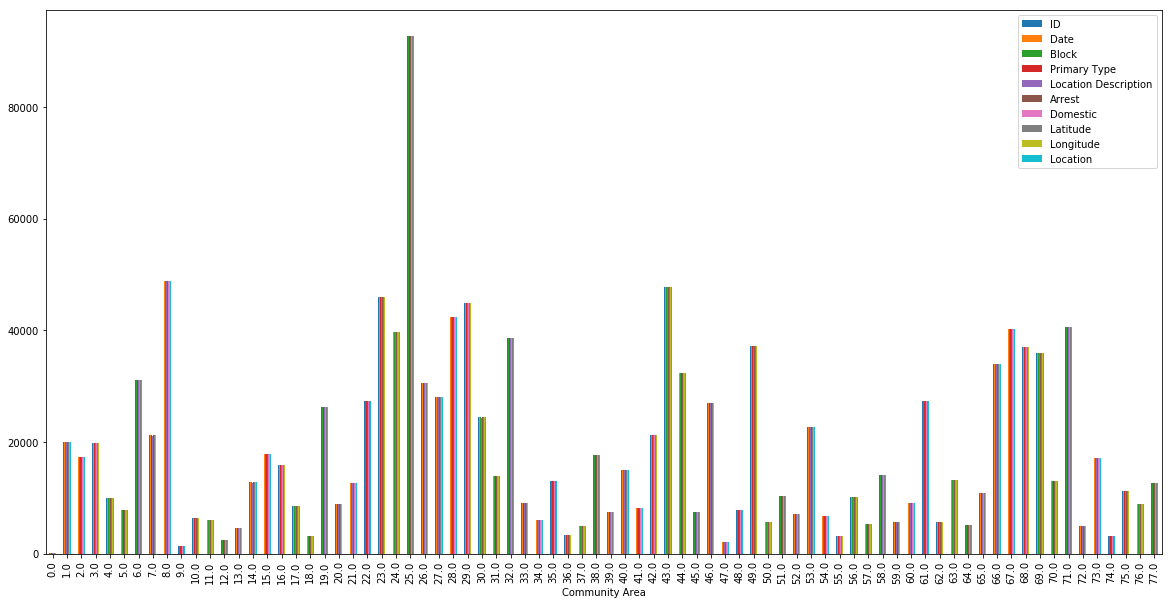

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
77621,8421956,01/01/2012 11:15:00 AM,083XX S HOLLAND RD,THEFT,DEPARTMENT STORE,True,False,NaN,41.742991,-87.632026,"(41.742991296, -87.632025815)"
80166,8427468,01/05/2012 12:30:00 PM,013XX W 105TH ST,THEFT,OTHER,False,False,NaN,41.703127,-87.656698,"(41.703127069, -87.656697951)"
84948,8436090,01/11/2012 07:00:00 AM,013XX W 105TH ST,THEFT,OTHER,False,False,NaN,41.703127,-87.656698,"(41.703127069, -87.656697951)"
87270,8440227,01/14/2012 06:51:00 PM,053XX S HARLEM AVE,NARCOTICS,STREET,True,False,NaN,41.795354,-87.801608,"(41.795354198, -87.801608429)"
91421,8447192,01/17/2012 07:45:00 AM,032XX W MONROE ST,THEFT,STREET,False,False,NaN,41.879634,-87.707974,"(41.879633871, -87.707973888)"
100161,8461905,01/30/2012 04:30:00 PM,052XX W OLIVE AVE,BURGLARY,CONSTRUCTION SITE,False,False,NaN,41.983996,-87.759958,"(41.983996419, -87.759958171)"
104058,8468856,02/04/2012 01:40:00 PM,084XX S HOLLAND RD,BATTERY,PARKING LOT/GARAGE(NON.RESID.),False,True,NaN,41.740990,-87.631971,"(41.740990358, -87.63197064)"
104816,8469806,02/02/2012 10:30:00 AM,057XX N LATROBE AVE,BATTERY,RESIDENCE,False,True,NaN,41.985080,-87.760335,"(41.985079514, -87.760334655)"
110635,8479349,02/13/2012 12:10:00 AM,055XX W HOMER ST,BATTERY,MOVIE HOUSE/THEATER,False,False,NaN,41.915055,-87.764231,"(41.915055487, -87.764231386)"
110768,8479550,02/11/2012 04:00:00 PM,052XX W OLIVE AVE,BURGLARY,VACANT LOT/LAND,False,False,NaN,41.983996,-87.759958,"(41.983996419, -87.759958171)"


In [14]:
comArea_subset = chiCrimes[['Community Area']]
comArea = chiCrimes[comArea_subset.isnull().any(axis=1)]
fig, ax = plt.subplots(figsize=(20, 10))
chiCrimes.groupby(["Community Area"]).count().plot(ax=ax, kind='bar') #plotting count for each community areas
plt.show()
comArea

We can see that the 22 null values all contain valid information except for the community area. We could drop those rows but let's try to maybe fill in the data, like we did with the Location values.

We can see that the 'Block' column contains an address, we can use that address to check if there is another row that contains the same address with the 'Community Area' column filled.

Let's take two random addresses and check the rows that contain that address in the 'block' column.

Also, by looking at the plot we can see that the community area also has 0.0 as community area, this is clearly invalid and we will need to address this as well.

In [15]:
chiCrimes.loc[chiCrimes['Block'] == "083XX S HOLLAND RD"]

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
2204,10515160,05/06/2016 09:00:00 AM,083XX S HOLLAND RD,DECEPTIVE PRACTICE,BANK,False,False,44.0,41.742991,-87.632026,"(41.742991296, -87.632025815)"
38855,9931616,01/19/2015 08:44:00 AM,083XX S HOLLAND RD,THEFT,VEHICLE-COMMERCIAL,False,False,44.0,41.742656,-87.632018,"(41.742656445, -87.632018466)"
65889,9983362,03/04/2015 04:15:00 PM,083XX S HOLLAND RD,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,False,44.0,41.742656,-87.632018,"(41.742656445, -87.632018466)"
77621,8421956,01/01/2012 11:15:00 AM,083XX S HOLLAND RD,THEFT,DEPARTMENT STORE,True,False,NaN,41.742991,-87.632026,"(41.742991296, -87.632025815)"
115345,8486711,02/18/2012 03:25:00 PM,083XX S HOLLAND RD,THEFT,GROCERY FOOD STORE,False,False,NaN,41.742991,-87.632026,"(41.742991296, -87.632025815)"
121757,8496554,02/26/2012 06:35:00 PM,083XX S HOLLAND RD,ASSAULT,PARKING LOT/GARAGE(NON.RESID.),False,False,NaN,41.742991,-87.632026,"(41.742991296, -87.632025815)"
156690,8554222,04/05/2012 08:16:00 PM,083XX S HOLLAND RD,THEFT,CONVENIENCE STORE,True,False,44.0,41.742991,-87.632026,"(41.742991296, -87.632025815)"
189072,8607408,05/10/2012 09:50:00 PM,083XX S HOLLAND RD,ROBBERY,SIDEWALK,True,False,44.0,41.742947,-87.632023,"(41.742947368, -87.632022629)"
190639,8609766,05/12/2012 04:55:00 PM,083XX S HOLLAND RD,ROBBERY,SMALL RETAIL STORE,False,False,44.0,41.742991,-87.632026,"(41.742991296, -87.632025815)"
192806,8613158,05/11/2012 04:00:00 PM,083XX S HOLLAND RD,THEFT,OTHER,False,False,44.0,41.742991,-87.632026,"(41.742991296, -87.632025815)"


In [16]:
chiCrimes.loc[chiCrimes['Block'] == "055XX W HOMER ST"]

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
29698,9913376,01/02/2015 08:00:00 PM,055XX W HOMER ST,BATTERY,OTHER,False,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"
32901,9920703,01/09/2015 11:00:00 PM,055XX W HOMER ST,THEFT,OTHER,False,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"
52906,9958748,02/10/2015 02:00:00 PM,055XX W HOMER ST,THEFT,MOVIE HOUSE/THEATER,False,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"
55318,9962847,02/14/2015 10:02:00 PM,055XX W HOMER ST,CRIMINAL TRESPASS,MOVIE HOUSE/THEATER,True,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"
64096,9979313,03/01/2015 06:45:00 PM,055XX W HOMER ST,THEFT,MOVIE HOUSE/THEATER,False,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"
110635,8479349,02/13/2012 12:10:00 AM,055XX W HOMER ST,BATTERY,MOVIE HOUSE/THEATER,False,False,NaN,41.915055,-87.764231,"(41.915055487, -87.764231386)"
112950,8483029,02/15/2012 07:20:00 PM,055XX W HOMER ST,CRIMINAL DAMAGE,MOVIE HOUSE/THEATER,False,False,NaN,41.915055,-87.764180,"(41.915055232, -87.76417995)"
120969,8495544,02/25/2012 02:00:00 PM,055XX W HOMER ST,THEFT,VEHICLE NON-COMMERCIAL,False,False,NaN,41.915055,-87.764180,"(41.915055232, -87.76417995)"
183850,8598943,05/05/2012 04:00:00 PM,055XX W HOMER ST,CRIMINAL DAMAGE,VEHICLE NON-COMMERCIAL,False,False,25.0,41.915053,-87.764257,"(41.91505287, -87.764257128)"
244162,8692286,07/05/2012 01:45:00 PM,055XX W HOMER ST,THEFT,MOVIE HOUSE/THEATER,False,False,25.0,41.915055,-87.764180,"(41.915055232, -87.76417995)"


We can see that "083XX S HOLLAND RD" contains 112 rows and most of them have "44" in the 'Community Area' column.

Same story with "055XX W HOMER ST", most of the 78 rows have "25" in the 'Community Area' column.

Based on this observation, we can iterate through the rows in the dataframe we created prior, called comArea and contains the subset of our main dataframe (chiCrimes) that contains all the rows that have null value in the community area column.

Then we can find the most occurence of a value in community area for that block and replace the null value with the mode value.

In [18]:
for index, row in comArea.iterrows(): # iterating through community area with NaN value subset
    chiCrimes.at[index, 'Community Area'] = chiCrimes.loc[chiCrimes['Block'] == row['Block']].mode()["Community Area"][:1] # replacing nan value with the mode value for given block

comArea_subset = chiCrimes[['Community Area']]
comArea = chiCrimes[comArea_subset.isnull().any(axis=1)]
comArea

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
104816,8469806,02/02/2012 10:30:00 AM,057XX N LATROBE AVE,BATTERY,RESIDENCE,False,True,NaN,41.98508,-87.760335,"(41.985079514, -87.760334655)"


We can see that our approach worked on all but 1 record, "057XX N LATROBE AVE". We can drop the row or we can try to find out a way to fill in the community area.

Let's try to find if there are other blocks that contain "XX N LATROBE AVE" in the 'Block' column.

We can do that by using str.contains, which works much like 'LIKE' in SQL.

In [19]:
pd.set_option('display.max_rows', 1500) # changing so we can see all values
chiCrimes[chiCrimes['Block'].str.contains('XX N LATROBE AVE')].sort_values("Block")

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
757278,9527600,03/11/2014 07:00:00 PM,001XX N LATROBE AVE,SEX OFFENSE,APARTMENT,False,False,25.0,41.883301,-87.756394,"(41.883301178, -87.756393849)"
405403,8948456,09/01/2012 08:00:00 AM,001XX N LATROBE AVE,THEFT,STREET,False,False,25.0,41.883153,-87.756388,"(41.883152958, -87.756387838)"
915448,9797385,09/28/2014 05:20:00 AM,001XX N LATROBE AVE,THEFT,RESIDENCE,False,True,25.0,41.883024,-87.756382,"(41.883023947, -87.756381654)"
979450,9906867,12/28/2014 03:35:00 PM,001XX N LATROBE AVE,BURGLARY,RESIDENCE,True,False,25.0,41.883534,-87.756403,"(41.883534484, -87.756402767)"
340637,8844762,10/14/2012 03:10:00 PM,001XX N LATROBE AVE,CRIMINAL DAMAGE,STREET,False,True,25.0,41.883449,-87.756400,"(41.883449397, -87.75639986)"
406306,8949541,12/30/2012 02:11:00 PM,001XX N LATROBE AVE,OTHER OFFENSE,STREET,False,False,25.0,41.883301,-87.756394,"(41.883301178, -87.756393849)"
1113433,10225328,09/06/2015 03:30:00 AM,001XX N LATROBE AVE,BATTERY,ALLEY,False,False,25.0,41.882961,-87.756382,"(41.882960832, -87.756382222)"
569805,9213934,07/13/2013 04:20:00 AM,001XX N LATROBE AVE,PUBLIC PEACE VIOLATION,SIDEWALK,True,False,25.0,41.883364,-87.756397,"(41.883364311, -87.756396953)"
572015,9217098,07/14/2013 06:00:00 AM,001XX N LATROBE AVE,BATTERY,RESIDENCE PORCH/HALLWAY,False,True,25.0,41.883175,-87.756388,"(41.883174911, -87.75638764)"
1303784,10582497,07/01/2016 02:40:00 PM,001XX N LATROBE AVE,BATTERY,SIDEWALK,False,True,25.0,41.883534,-87.756403,"(41.883534484, -87.756402767)"


We can see that there are 1.316 rows that contain "XX N LATROBE AVE" in the name! The rows contain three different values in the 'Community Area' column, along with our null value.

Looking at the data we can see that there are trends in the data that we can look at to try to classify the null value.

Blocks 001 to 018 contain "25" in the 'Community Area' column.
Blocks 019 to 023 contain "19" in the 'Community Area' column.
Blocks 052 to 056 contain "11" in the 'Community Area' column.

Based on these we must conclude that block 057 community area must be "11". We can verify this by looking up the location of 056 and 057 and checking if they are close to each other.

Let's change the Community Area to 11 for that row at index 104816 and then check how many null values there are.

In [20]:
pd.set_option('display.max_rows', 20) # changing back
chiCrimes.at[104816, 'Community Area'] = 11.0 # changing community area t 11.0 for row at index 104816
chiCrimes.isnull().sum()

ID                         0
Date                       0
Block                      0
Primary Type               0
Location Description    1226
Arrest                     0
Domestic                   0
Community Area             0
Latitude                   0
Longitude                  0
Location                   0
dtype: int64

No null values for Community Area, but we also need to take care of the rows that had "Community Area" at 0.0, let's use the same approach as we used for the null values and try to classify them based on the 'Block'.

Let's first create a subset and check out these rows.

In [22]:
zeroSubset = chiCrimes.loc[chiCrimes['Community Area'] == 0.0] # subset for 0.0 locations
zeroSubset

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
43786,9940426,01/14/2015 10:15:00 AM,007XX W OHARE ST,CRIMINAL TRESPASS,AIRPORT EXTERIOR - SECURE AREA,True,False,0.0,42.006074,-87.927365,"(42.006074109, -87.927364891)"
116101,8487665,02/19/2012 06:54:00 PM,051XX S RUTHERFORD AVE,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False,0.0,41.799090,-87.790549,"(41.799089601, -87.790549465)"
132444,8514335,03/05/2012 02:35:00 PM,007XX W OHARE ST,CRIMINAL TRESPASS,AIRPORT EXTERIOR - SECURE AREA,True,False,0.0,42.006074,-87.927365,"(42.006074109, -87.927364891)"
186232,8602602,05/04/2012 04:30:00 AM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"
220291,8655272,05/21/2012 02:05:00 PM,064XX N MANNHEIM RD,NARCOTICS,STREET,True,False,0.0,41.995722,-87.884463,"(41.99572241, -87.884462932)"
221417,8657230,05/25/2012 05:55:00 AM,007XX W OHARE ST,DECEPTIVE PRACTICE,AIRPORT EXTERIOR - NON-SECURE AREA,True,False,0.0,42.006074,-87.927365,"(42.006074109, -87.927364891)"
374947,8898623,11/16/2012 10:00:00 AM,056XX N FAIRVIEW AVE,DECEPTIVE PRACTICE,RESIDENCE,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
471537,9058946,03/22/2013 09:00:00 PM,056XX N FAIRVIEW AVE,CRIMINAL DAMAGE,DRIVEWAY - RESIDENTIAL,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
559040,9197341,06/23/2013 08:15:00 PM,007XX W OHARE ST,THEFT,AIRPORT EXTERIOR - SECURE AREA,False,False,0.0,42.006074,-87.927365,"(42.006074109, -87.927364891)"
715002,9451711,12/19/2013 01:35:00 PM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"


We can see that there are 13 records, but each has a valid information except for the community area.

Let's try to classify them based on the Block information.

In [23]:
for index, row in zeroSubset.iterrows():
    chiCrimes.at[index, 'Community Area'] = chiCrimes.loc[chiCrimes['Block'] == row['Block']].mode()["Community Area"][:1]
    
zeroSubset = chiCrimes.loc[chiCrimes['Community Area'] == 0.0]
zeroSubset

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
186232,8602602,05/04/2012 04:30:00 AM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"
220291,8655272,05/21/2012 02:05:00 PM,064XX N MANNHEIM RD,NARCOTICS,STREET,True,False,0.0,41.995722,-87.884463,"(41.99572241, -87.884462932)"
374947,8898623,11/16/2012 10:00:00 AM,056XX N FAIRVIEW AVE,DECEPTIVE PRACTICE,RESIDENCE,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
471537,9058946,03/22/2013 09:00:00 PM,056XX N FAIRVIEW AVE,CRIMINAL DAMAGE,DRIVEWAY - RESIDENTIAL,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
715002,9451711,12/19/2013 01:35:00 PM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"
739209,9494842,02/11/2014 10:30:00 PM,056XX N FAIRVIEW AVE,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,False,0.0,41.982993,-87.834219,"(41.982993154, -87.834218775)"
933404,9827727,10/12/2014 02:30:00 PM,065XX N MANNHEIM RD,CRIMINAL DAMAGE,STREET,False,False,0.0,41.997336,-87.884466,"(41.997336014, -87.884466308)"
1137038,10266945,10/08/2015 10:00:00 AM,056XX N FAIRVIEW AVE,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False,0.0,41.983029,-87.834185,"(41.983028684, -87.834185395)"


This leaves us with 8 rows which contain these three addresses:
* 064XX N MANNHEIM RD
* 065XX N MANNHEIM RD
* 056XX N FAIRVIEW AVE

Let's try to classify them based on matching just the Street

In [25]:
chiCrimes[(chiCrimes['Block'].str.contains("N MANNHEIM RD"))
          | (chiCrimes['Block'].str.contains("N FAIRVIEW AVE"))].sort_values("Community Area") # finding all community areas for given blocks

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
186232,8602602,05/04/2012 04:30:00 AM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"
220291,8655272,05/21/2012 02:05:00 PM,064XX N MANNHEIM RD,NARCOTICS,STREET,True,False,0.0,41.995722,-87.884463,"(41.99572241, -87.884462932)"
374947,8898623,11/16/2012 10:00:00 AM,056XX N FAIRVIEW AVE,DECEPTIVE PRACTICE,RESIDENCE,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
471537,9058946,03/22/2013 09:00:00 PM,056XX N FAIRVIEW AVE,CRIMINAL DAMAGE,DRIVEWAY - RESIDENTIAL,False,False,0.0,41.983018,-87.834197,"(41.983017755, -87.834196515)"
715002,9451711,12/19/2013 01:35:00 PM,065XX N MANNHEIM RD,MOTOR VEHICLE THEFT,STREET,False,False,0.0,41.997193,-87.884464,"(41.997193305, -87.884463632)"
739209,9494842,02/11/2014 10:30:00 PM,056XX N FAIRVIEW AVE,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,False,0.0,41.982993,-87.834219,"(41.982993154, -87.834218775)"
933404,9827727,10/12/2014 02:30:00 PM,065XX N MANNHEIM RD,CRIMINAL DAMAGE,STREET,False,False,0.0,41.997336,-87.884466,"(41.997336014, -87.884466308)"
1137038,10266945,10/08/2015 10:00:00 AM,056XX N FAIRVIEW AVE,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False,0.0,41.983029,-87.834185,"(41.983028684, -87.834185395)"
141861,8529330,03/18/2012 12:30:00 AM,043XX N MANNHEIM RD,THEFT,GAS STATION,False,False,76.0,41.957636,-87.884013,"(41.957636499, -87.884013372)"
299262,8779513,08/19/2012 07:00:00 PM,060XX N MANNHEIM RD,CRIMINAL TRESPASS,AIRPORT EXTERIOR - NON-SECURE AREA,True,False,76.0,41.989725,-87.879896,"(41.989724844, -87.879896036)"


Looking at the data, we can safely classify the Mannheim Rd data as Community Area 76.
We can not classify the Fairview Ave data so we will be dropping those rows.

In [26]:
for index, row in zeroSubset.iterrows():
    if("N MANNHEIM RD" in row["Block"]):
        chiCrimes.at[index, "Community Area"] = 76.0
    else:
        chiCrimes = chiCrimes.drop(index)

zeroSubset = chiCrimes.loc[chiCrimes['Community Area'] == 0.0]
zeroSubset

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location


This leaves us with the Location Description, we can see that it contains 1226 null values, let's check the null values there

In [27]:
locDesc_subset = chiCrimes[['Location Description']]
chiCrimes[locDesc_subset.isnull().any(axis=1)]

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
98,10509988,05/03/2016 04:35:00 PM,029XX N SHEFFIELD AVE,DECEPTIVE PRACTICE,NaN,True,False,6.0,41.934969,-87.653937,"(41.934968944, -87.653936849)"
133,10511522,05/03/2016 08:00:00 AM,033XX N Page Ave,DECEPTIVE PRACTICE,NaN,False,False,17.0,41.940042,-87.827625,"(41.940042028, -87.827625466)"
471,10509989,05/04/2016 12:00:00 PM,047XX N KIMBALL AVE,DECEPTIVE PRACTICE,NaN,False,False,14.0,41.967316,-87.713331,"(41.96731629, -87.713331369)"
690,10511523,05/04/2016 10:00:00 AM,035XX N LAKE SHORE DR,DECEPTIVE PRACTICE,NaN,False,False,6.0,41.948068,-87.643126,"(41.948068465, -87.643126381)"
708,10512795,05/04/2016 11:30:00 AM,116XX S CARPENTER ST,DECEPTIVE PRACTICE,NaN,False,False,53.0,41.682615,-87.648153,"(41.682614691, -87.648152509)"
909,10509982,04/29/2015 01:20:00 PM,026XX N KEDZIE AVE,DECEPTIVE PRACTICE,NaN,False,False,22.0,41.928593,-87.707738,"(41.92859251, -87.707738486)"
1930,10512796,05/06/2016 09:45:00 AM,083XX S BAKER AVE,DECEPTIVE PRACTICE,NaN,False,False,46.0,41.742589,-87.548984,"(41.742588895, -87.548983923)"
3698,10479906,04/08/2016 12:02:00 AM,016XX S MARSHFIELD AVE,OTHER OFFENSE,NaN,False,False,31.0,41.859224,-87.666879,"(41.859224265, -87.666878855)"
3831,10486305,02/05/2015 02:15:00 AM,037XX W DICKENS AVE,DECEPTIVE PRACTICE,NaN,False,False,22.0,41.919069,-87.720284,"(41.919069102, -87.720283809)"
4472,10518589,05/04/2016 02:00:00 PM,008XX E 79TH ST,DECEPTIVE PRACTICE,NaN,False,False,69.0,41.751293,-87.604637,"(41.751292524, -87.604636854)"


There is nothing that we can base the Location Description on so here we will just fill the null values with 'OTHER', and let's check how many null values are left.

In [28]:
chiCrimes = chiCrimes.fillna('OTHER')
chiCrimes.isnull().sum()

ID                      0
Date                    0
Block                   0
Primary Type            0
Location Description    0
Arrest                  0
Domestic                0
Community Area          0
Latitude                0
Longitude               0
Location                0
dtype: int64

Now we have dealt with all the null values, let's check out how many rows we have left

In [29]:
chiCrimes.count()

ID                      1419609
Date                    1419609
Block                   1419609
Primary Type            1419609
Location Description    1419609
Arrest                  1419609
Domestic                1419609
Community Area          1419609
Latitude                1419609
Longitude               1419609
Location                1419609
dtype: int64

We are left with 1.419.609 rows that contain no null values and that we can work with.

Since we will be using date, let's convert it to a better format along with checking if it's between 01/01/2012 to 31/12/2017.


In [30]:
chiCrimes['Date'] = pd.to_datetime(chiCrimes['Date'], format='%m/%d/%Y %I:%M:%S %p')

chiCrimes.sort_values('Date')

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
158639,8557056,2012-01-01 00:00:00,035XX W 60TH PL,BATTERY,RESIDENCE,False,True,66.0,41.783396,-87.711257,"(41.783396397, -87.711256524)"
78098,8422774,2012-01-01 00:00:00,044XX W MADISON ST,THEFT,BAR OR TAVERN,False,False,26.0,41.880600,-87.736438,"(41.880600386, -87.73643811)"
141121,8527846,2012-01-01 00:00:00,027XX W WELLINGTON AVE,THEFT,OTHER,False,False,21.0,41.935756,-87.695937,"(41.935755885, -87.695936975)"
347985,8856125,2012-01-01 00:00:00,006XX W CORNELIA AVE,THEFT,RESIDENCE,False,False,6.0,41.945463,-87.646573,"(41.945462922, -87.646573015)"
247998,8697316,2012-01-01 00:00:00,027XX S EMERALD AVE,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,False,60.0,41.844020,-87.645207,"(41.844019513, -87.645207358)"
341523,8846359,2012-01-01 00:00:00,034XX W 12TH PL,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,False,29.0,41.865185,-87.711492,"(41.865185282, -87.711492252)"
111955,8481432,2012-01-01 00:00:00,066XX N SEELEY AVE,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,False,2.0,42.002491,-87.681486,"(42.002490631, -87.681485671)"
223003,8660003,2012-01-01 00:00:00,006XX W GRACE ST,THEFT,RESIDENCE,False,False,6.0,41.951980,-87.646514,"(41.951980072, -87.646514088)"
761520,9535590,2012-01-01 00:00:00,092XX S DREXEL AVE,DECEPTIVE PRACTICE,APARTMENT,False,False,47.0,41.727193,-87.600964,"(41.727193361, -87.600963809)"
537692,9163847,2012-01-01 00:00:00,073XX S BELL AVE,THEFT,RESIDENCE,False,False,66.0,41.760455,-87.679356,"(41.760455282, -87.679355781)"


We can see that the last date is 2017-01-18, let's check at crimes in 2017 to see if there is something missing.

In [31]:
chiCrimes[chiCrimes['Date'].dt.year == 2017]

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
1444502,23059,2017-01-01 05:19:00,046XX N BROADWAY,HOMICIDE,TAVERN,False,False,3.0,41.966082,-87.657908,"(41.966081547, -87.657908498)"
1444503,23060,2017-01-01 06:18:00,046XX W MONROE ST,HOMICIDE,STREET,False,False,25.0,41.879291,-87.741599,"(41.879290642, -87.741598513)"
1446040,23061,2017-01-03 12:20:00,034XX W FULTON BLVD,HOMICIDE,STREET,False,False,27.0,41.886341,-87.712000,"(41.886340707, -87.711999596)"
1446041,23062,2017-01-03 23:52:00,032XX W LEXINGTON ST,HOMICIDE,ALLEY,False,False,27.0,41.871868,-87.706610,"(41.871868444, -87.706610311)"
1446661,23063,2017-01-04 00:41:00,034XX W FULTON BLVD,HOMICIDE,STREET,False,False,27.0,41.886341,-87.712000,"(41.886340707, -87.711999596)"
1446662,23064,2017-01-04 05:59:00,032XX W LEXINGTON ST,HOMICIDE,ALLEY,False,False,27.0,41.871868,-87.706610,"(41.871868444, -87.706610311)"
1447353,23065,2017-01-05 23:30:00,008XX E 46TH ST,HOMICIDE,AUTO,False,False,39.0,41.811366,-87.605611,"(41.811365671, -87.605610722)"
1447978,23066,2017-01-06 01:43:00,086XX S MARYLAND AVE,HOMICIDE,PORCH,False,False,44.0,41.737581,-87.603634,"(41.7375811, -87.603634068)"
1448668,23067,2017-01-07 10:07:00,013XX W HASTINGS ST,HOMICIDE,STREET,False,False,28.0,41.864273,-87.660233,"(41.864273353, -87.660232974)"
1450073,23068,2017-01-09 10:07:00,045XX W LEXINGTON ST,HOMICIDE,AUTO,False,False,26.0,41.871511,-87.738524,"(41.871511269, -87.738523703)"


Looking at the data we can see that there are only 30 rows of a total of 1.419.628 rows, since there are so few we are dropping all rows that have date of 2017.

In [32]:
chiCrimes = chiCrimes[chiCrimes['Date'].dt.year != 2017]
chiCrimes.sort_values('Date')

,ID,Date,Block,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location
470632,9057738,2012-01-01 00:00:00,003XX N MENARD AVE,THEFT,RESIDENCE,False,False,25.0,41.886288,-87.769970,"(41.886288459, -87.769969735)"
77290,8421429,2012-01-01 00:00:00,008XX N AVERS AVE,WEAPONS VIOLATION,RESIDENCE PORCH/HALLWAY,True,False,23.0,41.896342,-87.722441,"(41.896341861, -87.722440573)"
185197,8600787,2012-01-01 00:00:00,014XX N MONITOR AVE,SEX OFFENSE,RESIDENCE,False,False,25.0,41.906128,-87.771860,"(41.906127621, -87.771859909)"
172544,8580117,2012-01-01 00:00:00,037XX W LYNDALE ST,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,True,22.0,41.921814,-87.720493,"(41.921814446, -87.720492698)"
99438,8460773,2012-01-01 00:00:00,050XX W WARWICK AVE,SEX OFFENSE,RESIDENCE,False,False,15.0,41.948789,-87.753043,"(41.948789141, -87.753043017)"
78289,8423128,2012-01-01 00:00:00,007XX S STATE ST,ROBBERY,STREET,False,False,32.0,41.872894,-87.627560,"(41.872894484, -87.627560076)"
141121,8527846,2012-01-01 00:00:00,027XX W WELLINGTON AVE,THEFT,OTHER,False,False,21.0,41.935756,-87.695937,"(41.935755885, -87.695936975)"
291825,8767215,2012-01-01 00:00:00,015XX N LECLAIRE AVE,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,False,25.0,41.908336,-87.753461,"(41.908335854, -87.753460959)"
79261,8425158,2012-01-01 00:00:00,002XX W HURON ST,CRIMINAL DAMAGE,OTHER,False,False,8.0,41.894785,-87.634639,"(41.894784678, -87.634639268)"
79009,8424740,2012-01-01 00:00:00,014XX W FULLERTON AVE,BATTERY,APARTMENT,False,False,7.0,41.925194,-87.665083,"(41.925193578, -87.66508297)"


We have now removed the 30 rows that occured in 2017 and we are left with 1.419.579 rows. Let's check how many classes there are and which classes.

In [33]:
# looks good, let's check how many classes are in each column
print("BLOCK\n")
print(chiCrimes['Block'].value_counts())
print("\n\n")
print("---------------------------\n")
print("PRIMARY TYPE\n")
print(chiCrimes['Primary Type'].value_counts())
print("\n\n")
print("---------------------------\n")
print("LOCATION DESCRIPTION\n")
print(chiCrimes['Location Description'].value_counts())
print("\n\n")
print("---------------------------\n")
print("ARREST\n")
print(chiCrimes['Arrest'].value_counts())
print("\n\n")
print("---------------------------\n")
print("DOMESTIC\n")
print(chiCrimes['Domestic'].value_counts())
print("\n\n")
print("---------------------------\n")
print("COMMUNITY AREA\n")
print(chiCrimes['Community Area'].value_counts())
print("\n\n")
print("---------------------------\n")
print("LOCATION\n")
print(chiCrimes['Location'].value_counts())
print("\n\n")




BLOCK

001XX N STATE ST                       3570
0000X W TERMINAL ST                    2671
008XX N MICHIGAN AVE                   2432
076XX S CICERO AVE                     2092
0000X N STATE ST                       1811
064XX S DR MARTIN LUTHER KING JR DR    1319
083XX S STEWART AVE                    1201
063XX S DR MARTIN LUTHER KING JR DR    1116
051XX W MADISON ST                     1104
046XX W NORTH AVE                      1098
                                       ... 
017XX S LYNN WHITE DR                     1
038XX W 110TH ST                          1
007XX W 97TH ST                           1
0000X W RWY 14L                           1
000XX W 122ND ST                          1
113XX S ST LOUIS AVE                      1
009XX S Ashland ave                       1
010XX W Belmont Ave                       1
026XX W 100TH ST                          1
132XX S AVENUE F                          1
Name: Block, Length: 32620, dtype: int64



-------------------------

Looking at the blocks, we can see that there are 30.000+ different blocks! Since we will be working with the location, we will drop this column.

Looking at Primary Type, we can see that we can merge NON-CRIMINAL, NON - CRIMINAL and NON-CRIMINAL (SUBJECT SPECIFIED) into one class called NON-CRIMINAL. That will leave us with 31 classes for Primary Type.




In [34]:
# dropping Block column
chiCrimes = chiCrimes.drop('Block', axis=1)

# changing NON - CRIMINAL TO NON-CRIMINAL
chiCrimes.loc[chiCrimes['Primary Type'].isin(['NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)']), chiCrimes.columns=='Primary Type'] = 'NON-CRIMINAL'


print("PRIMARY TYPE\n")
print(chiCrimes['Primary Type'].value_counts())

PRIMARY TYPE

THEFT                                322430
BATTERY                              258942
CRIMINAL DAMAGE                      152813
NARCOTICS                            131175
ASSAULT                               89511
OTHER OFFENSE                         85362
BURGLARY                              81673
DECEPTIVE PRACTICE                    68355
MOTOR VEHICLE THEFT                   59858
ROBBERY                               56096
                                      ...  
LIQUOR LAW VIOLATION                   1928
KIDNAPPING                             1075
STALKING                                774
INTIMIDATION                            643
OBSCENITY                               169
NON-CRIMINAL                            122
CONCEALED CARRY LICENSE VIOLATION        84
PUBLIC INDECENCY                         61
OTHER NARCOTIC VIOLATION                 30
HUMAN TRAFFICKING                        20
Name: Primary Type, Length: 31, dtype: int64


#### Community Area dataset

Let's look at our other dataset, the Community Area data.

In [40]:
chiComArea = pd.read_csv('chicago-community-areas.csv', header=None) # Reads the .csv file and converts it to a dataframe called chiCrimes
chiComArea.info() # Displays the information about the database
chiComArea.head(10) # Displays all the 10 entries in the database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 78 columns):
0     10 non-null object
1     10 non-null object
2     10 non-null object
3     10 non-null object
4     10 non-null object
5     10 non-null object
6     10 non-null object
7     10 non-null object
8     10 non-null object
9     10 non-null object
10    10 non-null object
11    10 non-null object
12    10 non-null object
13    10 non-null object
14    10 non-null object
15    10 non-null object
16    10 non-null object
17    10 non-null object
18    10 non-null object
19    10 non-null object
20    10 non-null object
21    10 non-null object
22    10 non-null object
23    10 non-null object
24    10 non-null object
25    10 non-null object
26    10 non-null object
27    10 non-null object
28    10 non-null object
29    10 non-null object
30    10 non-null object
31    10 non-null object
32    10 non-null object
33    10 non-null object
34    10 non-null object
35    10 non-null objec

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,Community Area,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
1,name,Rogers Park,West Ridge,Uptown,Lincoln Square,North Center,Lake View,Lincoln Park,Near North Side,Edison Park,...,Englewood,Greater Grand Crossing,Ashburn,Auburn Gresham,Beverly,Washington Heights,Mount Greenwood,Morgan Park,O'Hare,Edgewater
2,population,54991,71942,56362,39493,31867,94368,64116,80484,11187,...,30654,32602,41081,48743,20034,26493,19093,22544,12756,56521
3,income,39482,47323,40324,57749,81524,70746,82707,76290,77678,...,19743,29663,62238,34767,83092,42053,80505,56886,49601,43331
4,requests,3204.8880725907,3906.3412193156,2164.0466981295,3827.2605271849,5307.9988703031,2742.2431332668,3408.6655437027,1717.6084687635,4754.6259050653,...,5459.646375673,6296.85295381,5599.4255251814,5785.446115344,6985.125287016,6641.7544256946,4357.6179751737,6264.1944641542,1552.9946691765,2564.8873869877
5,latinos,0.244,0.204,0.142,0.191,0.136,0.076,0.056,0.049,0.078,...,0.011,0.012,0.368,0.009,0.046,0.01,0.072,0.027,0.095,0.165
6,blacks,0.263,0.111,0.2,0.038,0.023,0.039,0.043,0.108,0.003,...,0.974,0.969,0.462,0.978,0.341,0.974,0.052,0.667,0.032,0.143
7,white,0.393,0.427,0.516,0.631,0.773,0.804,0.829,0.721,0.884,...,0.003,0.006,0.152,0.003,0.588,0.005,0.86,0.287,0.772,0.547
8,asian,0.064,0.225,0.114,0.111,0.045,0.06,0.051,0.101,0.024,...,0.001,0.001,0.007,0.001,0.006,0,0.007,0.004,0.083,0.116
9,other,0.036,0.032,0.028,0.029,0.022,0.021,0.021,0.02,0.012,...,0.011,0.013,0.011,0.009,0.019,0.012,0.01,0.014,0.019,0.029


First thing we need to do is to drop the requests row, we can see that the row is at index 4 so we will drop the row at index 4. 

Then we will need reshape the data to fit our other dataset, we will do that by transposing the data and then move the first row to our columns.

In [41]:
chiComArea = chiComArea.drop(chiComArea.index[4]) #dropping requests row
chiComArea = chiComArea.T # transposing
newHeader = chiComArea.iloc[0] # making first row header
chiComArea = chiComArea[1:] # removing first row from body
chiComArea.columns = newHeader # columns become the header

In [42]:
chiComArea.info() # Displays the information about the database
chiComArea.head(10) # Displays the top 10 entries in the database

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
Community Area    77 non-null object
name              77 non-null object
population        77 non-null object
income            77 non-null object
latinos           77 non-null object
blacks            77 non-null object
white             77 non-null object
asian             77 non-null object
other             77 non-null object
dtypes: object(9)
memory usage: 6.0+ KB


,Community Area,name,population,income,latinos,blacks,white,asian,other
1,1,Rogers Park,54991,39482,0.244,0.263,0.393,0.064,0.036
2,2,West Ridge,71942,47323,0.204,0.111,0.427,0.225,0.032
3,3,Uptown,56362,40324,0.142,0.2,0.516,0.114,0.028
4,4,Lincoln Square,39493,57749,0.191,0.038,0.631,0.111,0.029
5,5,North Center,31867,81524,0.136,0.023,0.773,0.045,0.022
6,6,Lake View,94368,70746,0.076,0.039,0.804,0.06,0.021
7,7,Lincoln Park,64116,82707,0.056,0.043,0.829,0.051,0.021
8,8,Near North Side,80484,76290,0.049,0.108,0.721,0.101,0.02
9,9,Edison Park,11187,77678,0.078,0.003,0.884,0.024,0.012
10,10,Norwood Park,37023,64477,0.12,0.004,0.815,0.046,0.015


We have our dataframe like we want it, but all the columns show dtype as object, we clearly want to change some of them to either float or int.

In [43]:
chiComArea['Community Area'] = chiComArea['Community Area'].astype(float)
chiComArea['population'] = chiComArea.population.astype(int)
chiComArea['income'] = chiComArea.income.astype(int)
chiComArea['latinos'] = chiComArea.latinos.astype(float)
chiComArea['blacks'] = chiComArea.blacks.astype(float)
chiComArea['white'] = chiComArea.white.astype(float)
chiComArea['asian'] = chiComArea.asian.astype(float)
chiComArea['other'] = chiComArea.other.astype(float)
print(chiComArea.info())
chiComArea.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
Community Area    77 non-null float64
name              77 non-null object
population        77 non-null int32
income            77 non-null int32
latinos           77 non-null float64
blacks            77 non-null float64
white             77 non-null float64
asian             77 non-null float64
other             77 non-null float64
dtypes: float64(6), int32(2), object(1)
memory usage: 5.4+ KB
None


,Community Area,name,population,income,latinos,blacks,white,asian,other
1,1.0,Rogers Park,54991,39482,0.244,0.263,0.393,0.064,0.036
2,2.0,West Ridge,71942,47323,0.204,0.111,0.427,0.225,0.032
3,3.0,Uptown,56362,40324,0.142,0.200,0.516,0.114,0.028
4,4.0,Lincoln Square,39493,57749,0.191,0.038,0.631,0.111,0.029
5,5.0,North Center,31867,81524,0.136,0.023,0.773,0.045,0.022


#### Joining the datasets together

Let's combine the datasets into one dataframe so that we can work with one file, we will merge the datasets using the community area columns.

In [44]:
df = chiCrimes.merge(chiComArea)
df.head(5)

,ID,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,Latitude,Longitude,Location,name,population,income,latinos,blacks,white,asian,other
0,10508693,2016-05-03 23:40:00,BATTERY,APARTMENT,True,True,29.0,41.864073,-87.706819,"(41.864073157, -87.706818608)",North Lawndale,35912,25797,0.06,0.914,0.014,0.002,0.01
1,10448396,2016-03-14 10:15:00,BURGLARY,APARTMENT,False,False,29.0,41.854753,-87.711234,"(41.854752959, -87.711233594)",North Lawndale,35912,25797,0.06,0.914,0.014,0.002,0.01
2,10495378,2016-04-22 11:21:00,WEAPONS VIOLATION,VACANT LOT/LAND,True,False,29.0,41.859931,-87.709139,"(41.859930986, -87.709138696)",North Lawndale,35912,25797,0.06,0.914,0.014,0.002,0.01
3,20859,2013-05-01 01:26:00,HOMICIDE,ALLEY,True,False,29.0,41.854302,-87.713697,"(41.854302497, -87.713697274)",North Lawndale,35912,25797,0.06,0.914,0.014,0.002,0.01
4,10508736,2016-05-04 02:08:00,ASSAULT,APARTMENT,True,True,29.0,41.867265,-87.713917,"(41.86726481, -87.713917226)",North Lawndale,35912,25797,0.06,0.914,0.014,0.002,0.01


Now we have merged the datasets together into a new dataframe called df on Community Area.

Let's make sure the new dataframe doesn't contain any null values.

In [45]:
df.isnull().sum()

ID                      0
Date                    0
Primary Type            0
Location Description    0
Arrest                  0
Domestic                0
Community Area          0
Latitude                0
Longitude               0
Location                0
name                    0
population              0
income                  0
latinos                 0
blacks                  0
white                   0
asian                   0
other                   0
dtype: int64

Looks clean! Let's start exploring the attributes.

### Exploration

Let's check the data for all crimes in Chicago and if the crime for all crimes has been going up or down between 2012 to 2017.

First we will need to convert our date column into two new rows, year and month, so we can work with that data.

In [46]:
# adding two rows, year and month to our dataframe, which will contain the year and month
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month']=(df['Date'].dt.month).apply(lambda x: calendar.month_abbr[x])
df['Month'] = df['Month'] = pd.Categorical(df['Month'] , categories=
            ['Jan','Feb','Mar','Apr','May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
            ordered=True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Next let's plot a few things like the crime types, location descriptions for all crimes. Annual crime rates, monthly crime rates and hourly crime rates.

We want to know if Chicago is experiencing decreasing crime.

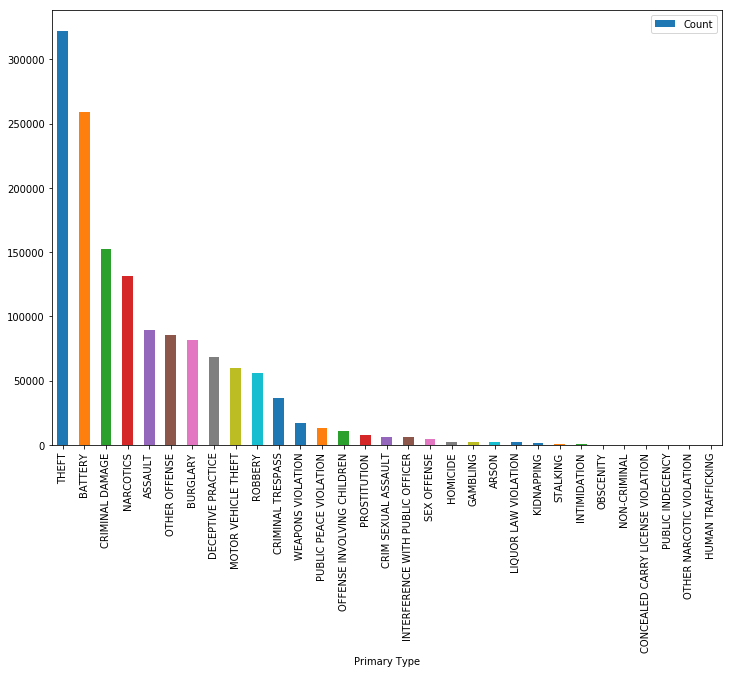

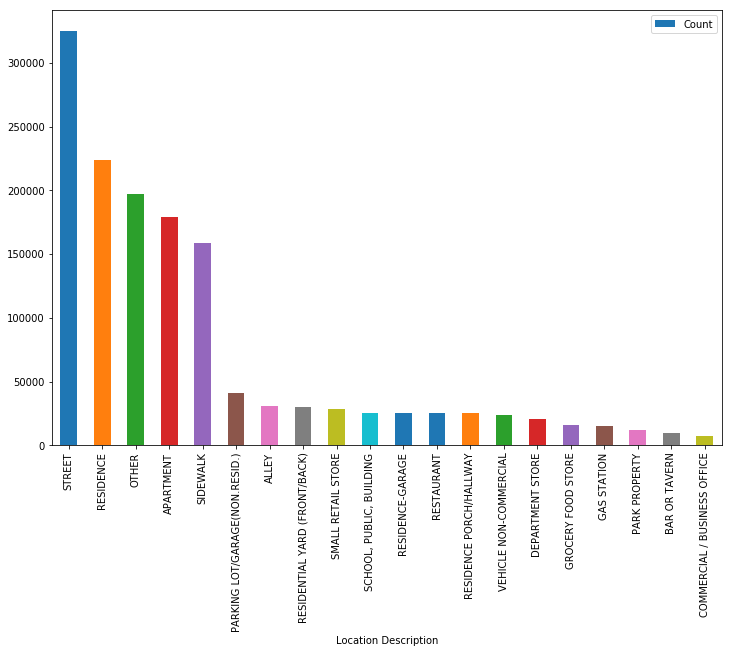

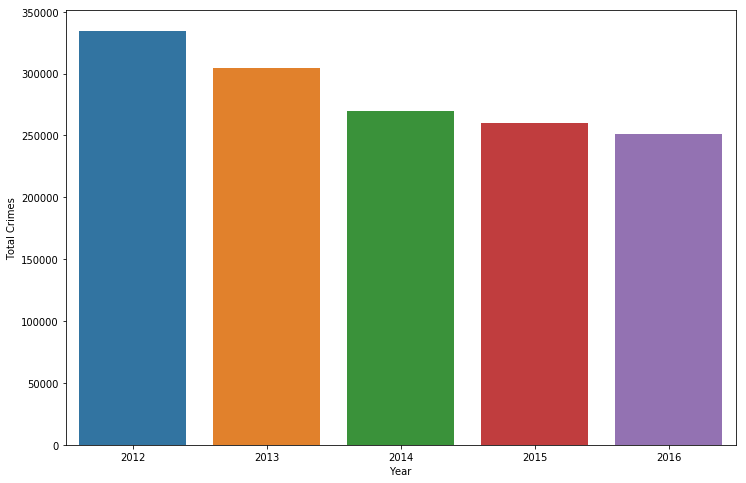

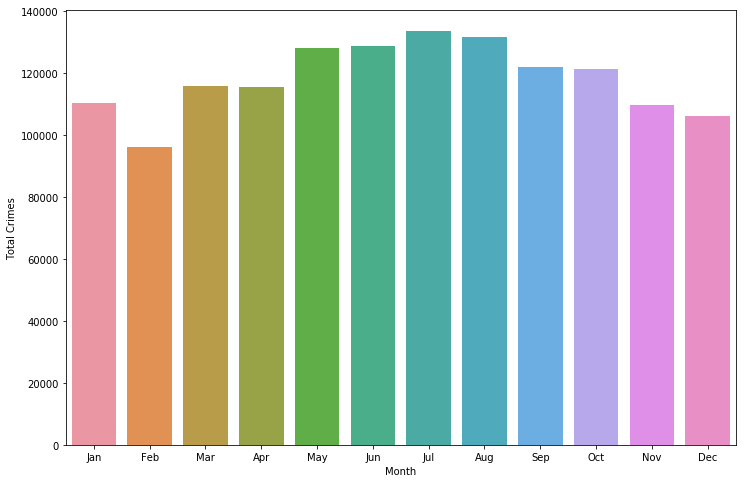

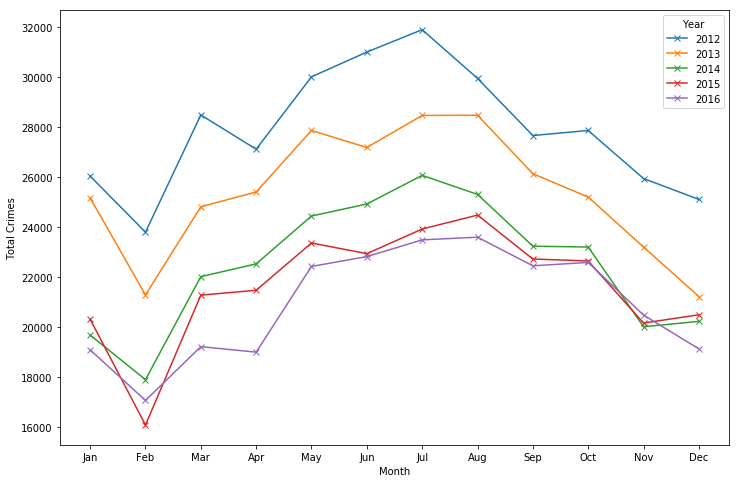

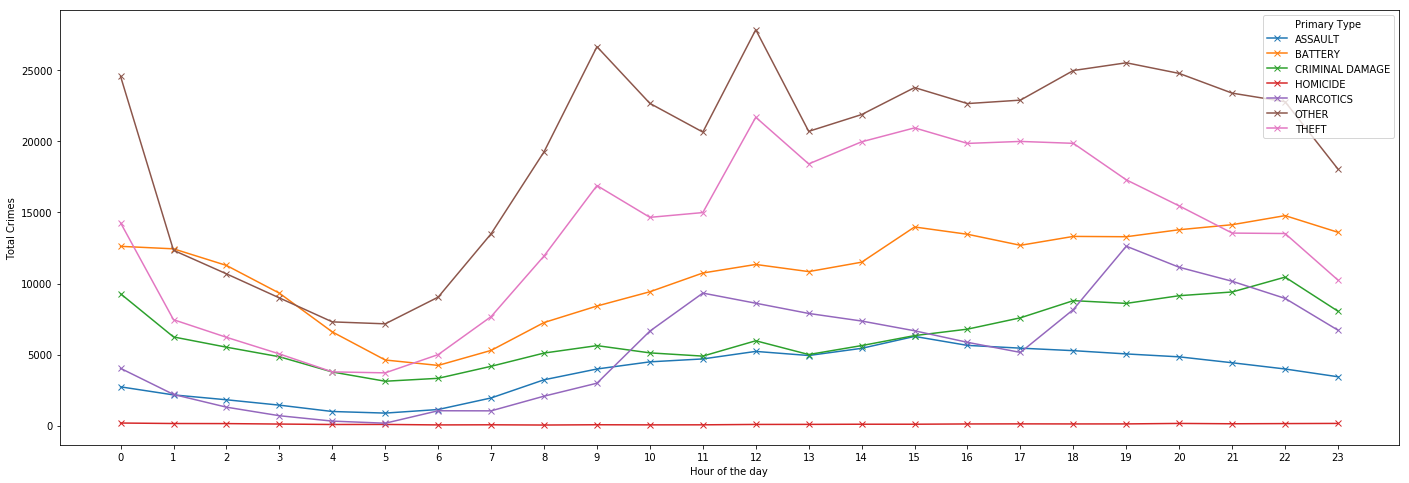

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
criCount = pd.DataFrame(df.groupby('Primary Type').size().sort_values(ascending=False).rename('Count').reset_index())
criCount.plot(x='Primary Type',y='Count', ax=ax, kind='bar')
plt.show()

#creating subset of df, where Location Description only has 20 top
top20Loc = chiCrimes.copy()
locToDo = list(chiCrimes['Location Description'].value_counts()[20:].index)
top20Loc.loc[top20Loc['Location Description'].isin(locToDo), top20Loc.columns=='Location Description'] = 'OTHER'

fig, ax = plt.subplots(figsize=(12, 8))
criCount = pd.DataFrame(top20Loc.groupby('Location Description').size().sort_values(ascending=False).rename('Count').reset_index())
criCount.plot(x='Location Description',y='Count', ax=ax, kind='bar')
plt.show()

sb.countplot(x='Year', data=df)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel('Total Crimes')
plt.show()

sb.countplot(x='Month', data=df)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel('Total Crimes')
plt.show()

df.groupby(['Month','Year'])['Date'].count().unstack().plot(figsize=(12,8), marker='x')
plt.xticks(np.arange(12), months)
plt.ylabel('Total Crimes')
plt.show()


chiPrim = chiCrimes.copy()
primToDo = list(chiCrimes['Primary Type'].value_counts()[5:].index)
primToDo.remove('HOMICIDE')
chiPrim.loc[chiPrim['Primary Type'].isin(primToDo), chiPrim.columns=='Primary Type'] = 'OTHER'
chiPrim

chiPrim.groupby([chiPrim['Date'].dt.hour, 'Primary Type'])['Date'].count().unstack().plot(figsize=(24,8), marker='x')
plt.xlabel('Hour of the day')
plt.ylabel('Total Crimes')
plt.xticks(np.arange(24))
plt.show()

We wanted to know the question wether Chicago crimes were going up in comparison to the low crime rate in US.

We can see that the occurrence of crimes in Chicago has been going down all 5 years in row. July 2012 had the most occurrence of crime in Chicago of all the months in those 5 years. But we can see that the month with the highest occurrence of crime in 2016 has lower occurrence than the lowest month in 2012. Chicago is clearly doing something right about their crime rates.

But we wanted to also know how the homicide rates are in Chicago. Half of the rise in homicides in US in 2016 came from Chicago. Was there a trend in increasing homicides or was it sudden? We can also see that the most occurrence of crime is on the streets, is it the same with homicides? Let's try to see if we can answer these questions.

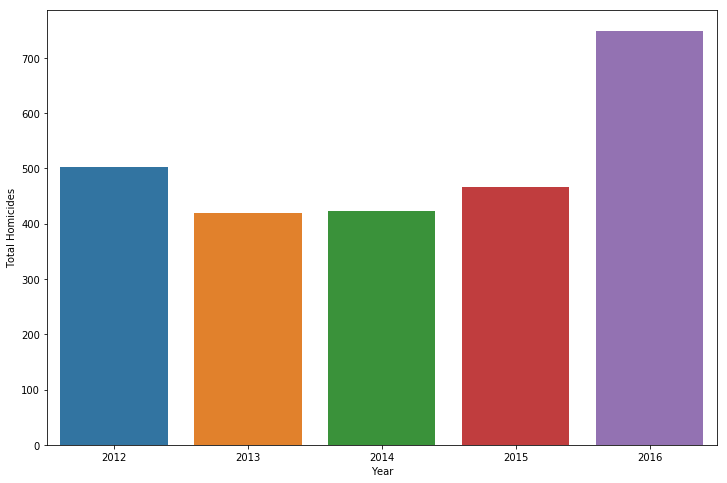

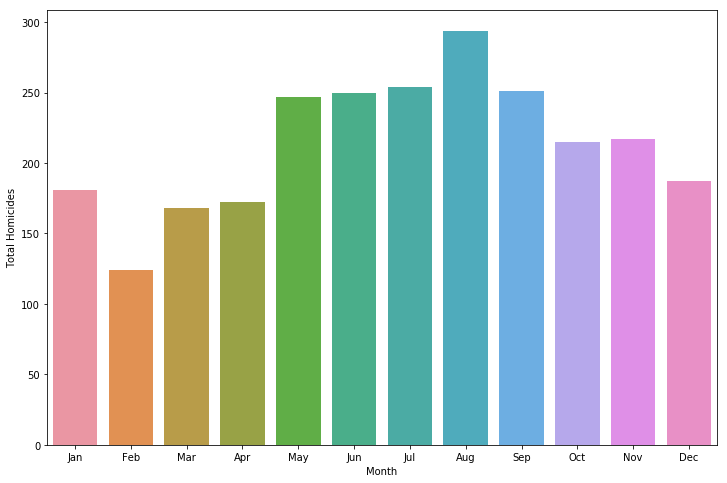

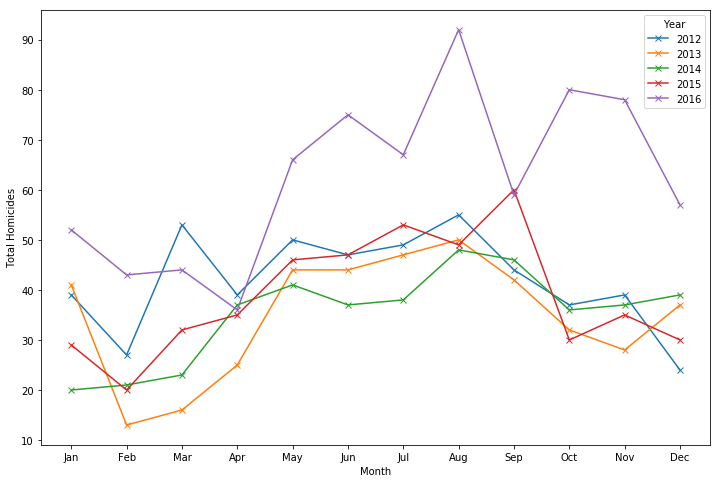

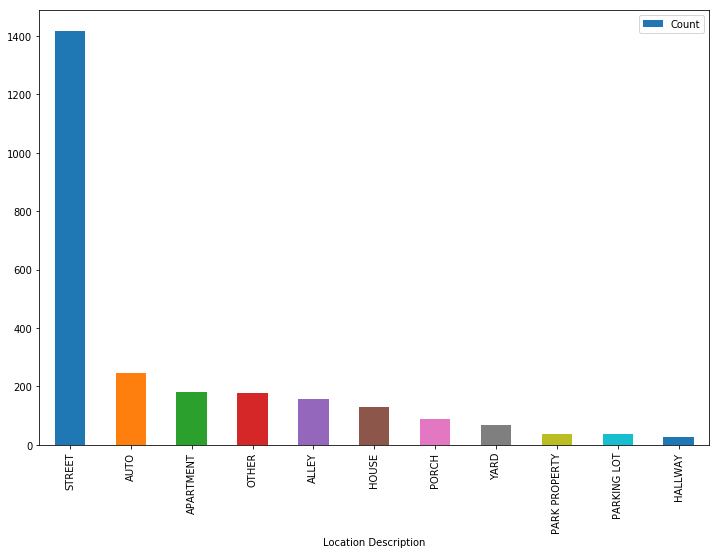

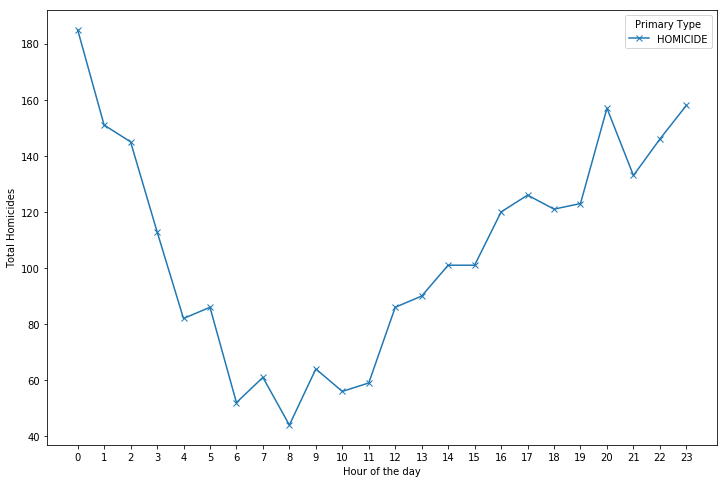

In [48]:
homSubset = df[df['Primary Type'] == 'HOMICIDE'] # subset with only homicides


sb.countplot(x='Year', data=homSubset)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel('Total Homicides')
plt.show()

sb.countplot(x='Month', data=homSubset)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel('Total Homicides')
plt.show()

homSubset.groupby(['Month','Year'])['Date'].count().unstack().plot(figsize=(12,8), marker='x')
plt.xticks(np.arange(12), months)
plt.ylabel('Total Homicides')
plt.show()




chiLoc = homSubset.copy()
locToDo = list(chiLoc['Location Description'].value_counts()[10:].index)
chiLoc.loc[chiLoc['Location Description'].isin(locToDo), chiLoc.columns=='Location Description'] = 'OTHER'

fig, ax = plt.subplots(figsize=(12,8))
homCount = pd.DataFrame(chiLoc.groupby('Location Description').size().sort_values(ascending=False).rename('Count').reset_index())
homCount.plot(x='Location Description',y='Count', ax=ax, kind='bar')
plt.show()


homSubset.groupby([homSubset['Date'].dt.hour, 'Primary Type'])['Date'].count().unstack().plot(figsize=(12,8), marker='x')
plt.xlabel('Hour of the day')
plt.ylabel('Total Homicides')
plt.xticks(np.arange(24))
plt.show()

We can see that the homicide rate dropped a little from 2013 to 2014, but then began an upward trend until 2016, when it took a leap in occurrences. Also, by looking at the monthly data, we can see that it increased significantly in May 2016 and was well above average for the following months in 2016.

Most homicides happened in the streets, like how all crime combined showed us, but the second highest occurrence was in an Auto, which did not show up in top 20 location descriptions for all crimes.

But where are the homicides happening in Chicago? Let's create a heatmap and check where the homicides are happening in Chicago.

In [49]:
#Generating our base map with Chicago
def generateBaseMap(default_location=[41.895140898, -87.624255632], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map = generateBaseMap()

In [50]:
df_copy = df[df['Primary Type'] == 'HOMICIDE'].copy()
df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=df_copy[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

We can see that homicides happen more in some areas than other areas in Chicago. The heatmap shows a higher rate in West Side and South Chicago, and much lower rate in North Side.

In [54]:
df_hour_list = []
for year in df_copy.Year.sort_values().unique():
    for month in df_copy.Month.sort_values().unique():
        df_hour_list.append(df_copy.loc[(df_copy.Year == year) & (df_copy.Month == month), ['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())

In [55]:
base_map = generateBaseMap(default_zoom_start=11)
plugins.HeatMapWithTime(df_hour_list).add_to(base_map)
base_map

In [58]:
comgeo = 'BoundariesCommunityAreas.geojson'

years = df.Year.sort_values().unique()

months = df.Month.sort_values().unique()

types = df['Primary Type'].sort_values().unique()

communityDict = {
    '1': [42.01,-87.67],
    '2': [42.0, -87.70],
    '3': [41.965,-87.655],
    '4': [41.975, -87.685],
    '5': [41.95, -87.685],
    '6': [41.94, -87.655],
    '7': [41.92, -87.655],
    '8': [41.9, -87.632],
    '9': [42.006, -87.815],
    '10': [41.987, -87.8], 
    '11': [41.98, -87.769],
    '12': [41.987, -87.752],
    '13': [41.985, -87.72],
    '14': [41.965, -87.72],
    '15': [41.95, -87.764],
    '16': [41.954, -87.725],
    '17': [41.945, -87.808],
    '18': [41.927, -87.8],
    '19': [41.925, -87.765],
    '20': [41.925, -87.73501],
    '21': [41.938, -87.71],
    '22': [41.923, -87.7],
    '23': [41.9, -87.725],
    '24': [41.9, -87.685],
    '25': [41.89, -87.761],
    '26': [41.878, -87.729],
    '27': [41.878, -87.705],
    '28': [41.874, -87.665],
    '29': [41.861, -87.714],
    '30': [41.84, -87.714],
    '31': [41.85, -87.664],
    '32': [41.876, -87.627],
    '33': [41.8555, -87.6199],
    '34': [41.84, -87.633],
    '35': [41.834, -87.6199],
    '36': [41.824, -87.602],
    '37': [41.811, -87.632],
    '38': [41.811, -87.617],
    '39': [41.809, -87.595],
    '40': [41.792, -87.617],
    '41': [41.792, -87.595],
    '42': [41.78, -87.595],
    '43': [41.763, -87.575],
    '44': [41.738, -87.615],
    '45': [41.742, -87.589],
    '46': [41.739, -87.548],
    '47': [41.728, -87.597],
    '48': [41.73, -87.575],
    '49': [41.709, -87.619],
    '50': [41.703, -87.598],
    '51': [41.692, -87.568],
    '52': [41.71, -87.535],
    '53': [41.672, -87.628],
    '54': [41.658, -87.603],
    '55': [41.65, -87.54],
    '56': [41.792, -87.77],
    '57': [41.809, -87.726],
    '58': [41.815, -87.70],
    '59': [41.83, -87.672],
    '60': [41.836, -87.648],
    '61': [41.809, -87.657],
    '62': [41.792, -87.726],
    '63': [41.795, -87.695],
    '64': [41.778, -87.77],
    '65': [41.77, -87.726],
    '66': [41.77, -87.695],
    '67': [41.775, -87.665],
    '68': [41.775, -87.644],
    '69': [41.764, -87.622],
    '70': [41.744, -87.708],
    '71': [41.742, -87.658],
    '72': [41.716, -87.673],
    '73': [41.716, -87.648],
    '74': [41.694, -87.708],
    '75': [41.688, -87.67],
    '76': [41.98, -87.91],
    '77': [41.985, -87.665]
}

extra = [True, False]

In [59]:
@interact(Year=years, Month=months, Type=types, Info=extra)
def create_map(Year=2016, Month='Jan', Type='ASSAULT', Info=False):
    dfsubset = df[(df['Primary Type'] == Type) & (df['Month'] == Month) & (df['Year'] == Year)].copy()
    mapset = pd.DataFrame(dfsubset['Community Area'].value_counts().astype(float))
    mapset.to_json('mapset.json')
    mapset = mapset.reset_index()
    mapset.columns = ['Community Area', 'Crime Count']
    
    chimap = folium.Map(location=[41.895140898, -87.624255632], zoom_start=10)
    folium.Choropleth(geo_data=comgeo,
                        data=mapset,
                        columns=['Community Area', 'Crime Count'],
                        key_on='feature.properties.area_num_1',
                        fill_color='OrRd',
                        fill_opacity=0.7,
                        line_opacity=0.2).add_to(chimap)
    
    if Info:
        feature_group = FeatureGroup(name='Community Area')
        dfsubset['count'] = 1
        grp = dfsubset.loc[:,['Community Area', 'name', 'count']].groupby(['Community Area', 'name']).sum().reset_index().values.tolist() 
        for row in grp:
            feature_group.add_child(Marker(communityDict[row[0]],'Area ' + row[0] + ', ' + row[1] + '\nIncidents: ' + str(row[2])))
        chimap.add_child(feature_group)
    return chimap

interactive(children=(Dropdown(description='Year', index=4, options=(2012, 2013, 2014, 2015, 2016), value=2016…

### Predictive Analysis

For predictive analysis, we decided to use a classifier, we will try to answer a few questions with a Decision Tree classifier.

First let's make a training data with features 'Location Description', 'Arrest', 'Domestic', 'name' and 'Primary Type' as target.

We will split the data into 75% training and 25% test.

In [62]:

X = pd.DataFrame()
X['Location Description'], locDescLabel = pd.factorize(df['Location Description'])
X['Arrest'] = df['Arrest']
X['Domestic'] = df['Domestic']
X['name'], nameLabel = pd.factorize(df['name'])
y = df[['Primary Type']]

features = list(X)
target = list(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Since Decision Trees can take a couple of various parameters, we will use kfold to find the optimal parameters to use.

In [63]:
params = {'criterion':['entropy', 'gini'],
         'max_depth':[None, 2, 3],
         'min_samples_leaf':[1, 2]
         }
kfold = model_selection.KFold(n_splits=3, random_state=42)

dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, params, cv=kfold, scoring='accuracy')
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [None, 2, 3], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Here we can see that the optimal criterion is 'gini', optimal max_depth is 'None' and min_samples_leaf is '1'. We will use these parameters when we are making our predictions.

In [64]:
rf = clf.best_estimator_
rf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

But how good was our prediction? Let's check the accuracy score and see how good our model will predict.

In [65]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.44207723411149774


We can see that the accuracy score is ~44%.

Let's make a prediction about the Primary Type of a crime that happened, we know that the crime happened in a residence in North Lawndale, the perpetrator was arrested and the crime was not classified as domestic. What is the most likely crime that occured?

In [66]:
#location, arrest, domestic, name
location = "RESIDENCE"
place = "North Lawndale"
arrested = 1
domestic = 0


locLst = locDescLabel.tolist()
locIdx = locLst.index(location)
placeLst = nameLabel.tolist()
placeIdx = placeLst.index(place)

pred1 = clf.predict([[locIdx, arrested, domestic, placeIdx]])
print("Our prediction says that the crime was: {}".format(pred1[0]))

Our prediction says that the crime was: NARCOTICS


We can see that according to our prediction, the crime was likely to be of a NARCOTICS nature.

But how about a crime that occured in an alley in Englewood, where an arrest was not made and it was not domestic?

In [67]:
#location, arrest, domestic, name
location = "ALLEY"
place = "Englewood"
arrested = 0
domestic = 0


locLst = locDescLabel.tolist()
locIdx = locLst.index(location)
placeLst = nameLabel.tolist()
placeIdx = placeLst.index(place)

pred1 = clf.predict([[locIdx, arrested, domestic, placeIdx]])
print("Our prediction says that the crime was: {}".format(pred1[0]))

Our prediction says that the crime was: ROBBERY


According to our prediction, the crime was likely to be a robbery.

Since the prediction score was only 44%, let's try other features and another target. Here we want to know how likely it is that we will be arrested for a given crime in a location description in a community area.

Let's make our decision tree, we are splitting 75/25 train/test.

In [69]:
X = pd.DataFrame()
X['Primary Type'], primTypeLabel = pd.factorize(df['Primary Type'])
X['Location Description'], locDescLabel = pd.factorize(df['Location Description'])
X['name'], nameLabel = pd.factorize(df['name'])
X['Domestic'] = df['Domestic']
y = df[['Arrest']]

features = list(X)
target = list(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's check the same parameters we used before when checking for the optimal parameters.

In [70]:
params = {'criterion':['entropy', 'gini'],
         'max_depth':[None, 2, 3],
         'min_samples_leaf':[1, 2]
         }
kfold = model_selection.KFold(n_splits=3, random_state=42)

dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, params, cv=kfold, scoring='accuracy')
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [None, 2, 3], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Here we can see that the optimal parameters are the same as in the previous example.

Next, let's train our data and make a prediction based on our test data to check how our accuracy score is.

In [71]:
dt = clf.best_estimator_
dt.fit(X_train, y_train.values.ravel())
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8777835697882472


The prediction accuracy is much higher here or: ~87%.

Let's try to predict something, let's imagine if we just committed a crime in Chicago and we want to know if we will be arrested.

The crime was theft in an alley in the neighbourhood of Austin and it was not domestic.

Let's check what the prediction is wether we will be arrested or not.

In [72]:
#Primary Type, Location Description, name, Domestic

primaryType = "THEFT"
locDesc = "ALLEY"
place = "Austin"
domestic = 0


locLst = locDescLabel.tolist()
locIdx = locLst.index(location)
placeLst = nameLabel.tolist()
placeIdx = placeLst.index(place)
primLst = primTypeLabel.tolist()
primIdx = primLst.index(primaryType)

pred2 = clf.predict([[primIdx, locIdx, placeIdx, domestic]])
if(not pred2):
    print("Our prediction says that we will not be arrested")
else:
    print("Our prediction says that we will be arrested")

Our prediction says that we will not be arrested


Our prediction model predicts that we will not be arrested given the variables.

But how about if we were arrested for prostitution in a hotel/motel in North Lawndale, which was non-domestic?

In [73]:
#Primary Type, Location Description, name, Domestic

primaryType = "PROSTITUTION"
locDesc = "HOTEL/MOTEL"
place = "North Lawndale"
domestic = 0


locLst = locDescLabel.tolist()
locIdx = locLst.index(location)
placeLst = nameLabel.tolist()
placeIdx = placeLst.index(place)
primLst = primTypeLabel.tolist()
primIdx = primLst.index(primaryType)

pred2 = clf.predict([[primIdx, locIdx, placeIdx, domestic]])
if(not pred2):
    print("Our prediction says that we will not be arrested")
else:
    print("Our prediction says that we will be arrested")

Our prediction says that we will be arrested


Our prediction is that we will be arrested, so it would be wise to steer clear from North Lawndale if you plan on prostituting in a hotel or motel.

### Conclusions

We found out that overall crime is going down in Chicago, but homicides are going up, including a sharp increase in 2016.

We aslo found out that most homicides happen in the south Chicago area according to our heatmap.

We built a classifier to find out what the most likely crime occurred given that we know location description, name of community area, if the perp was arrested and if the crime was classified as domestic.


Tldr; crime is going down but homicides are going up.